## Sentiment Analysis: Fake News Detection

Fake News involve the deliberate dissemination of misleading information, leading individuals astray. This can result in tangible real-world consequences, such as intentional deception, attention-seeking, public opinion manipulation, or reputation damage. The identification of fake news is crucial, particularly for media outlets aiming to attract viewers to their websites, generating online advertising revenue.

Dataset: [Utilizing a publicly available dataset](https://drive.google.com/file/d/1XoHoUjZtLQ6gh_CPv9_igtZoEsdkgq3t/view), it includes news text paired with corresponding labels (FAKE or REAL).

In [ ]:
import pandas as pd
import requests
import io
import numpy as np
import torch
import re
import string
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader
import gensim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report
from transformers import BertTokenizerFast, BertModel
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as data_utils
from torch.utils.data import Dataset, TensorDataset, DataLoader
import gensim

In [1]:
# Download stopwords and punkt if not already downloaded
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sezar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sezar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sezar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# First checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# First checking if GPU is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [4]:
# un-comment if using google colab
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded['news.csv']))

df = pd.read_csv("news.csv")

df.head(5)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
fake_percentage = (df['label'] == 'FAKE').mean() * 100
print(f"The percentage of rows labeled as 'FAKE' is: {fake_percentage:.2f}%")

The percentage of rows labeled as 'FAKE' is: 49.94%


We define a class TextPreprocessor to preprocess the text and add two columns 'clean_data' and 'tidy_data' to our model. We use this class in the following two models we create later.

In [6]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess(self, text):
        text = text.lower()
        text = re.sub(r'https?:\/\/\S+', '', text)
        text = re.sub(r'@[A-Za-z0-9]+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        filtered_tokens = [token for token in tokens if token.lower() not in self.stop_words]
        lemmatized_tokens = [self.lemmatizer.lemmatize(token) for token in filtered_tokens]
        stemmed_tokens = [self.stemmer.stem(token) for token in lemmatized_tokens]
        tokens = [word for word in stemmed_tokens if word not in string.punctuation]
        return ' '.join(tokens)

    def tokenize_text_column(self, df, clean_text_column_name='clean_text', tokenized_text_column_name='tidy_text'):
        df[tokenized_text_column_name] = df[clean_text_column_name].apply(lambda x: x.split())
        return df

    def add_clean_text_column(self, df, text_column_name='text', clean_text_column_name='clean_text'):
        tqdm.pandas()
        df[clean_text_column_name] = df[text_column_name].progress_apply(self.preprocess)
        return df

    def train_word2vec_model(self, df, embedding_size=200, epochs_w2v = 3):
        model_w2v = gensim.models.Word2Vec(
            df['tidy_text'],
            vector_size=embedding_size,  # desired no. of features/independent variables
            window=5,  # context window size
            min_count=2,  # Ignores all words with total frequency lower than 2.
            sg=1,  # 1 for skip-gram model
            hs=0,
            negative=10,  # for negative sampling
            workers=8,  # no.of cores
            seed=34
        )
        model_w2v.train(df['tidy_text'], total_examples=len(df['tidy_text']), epochs=epochs_w2v)
        return model_w2v

In [7]:
# preprocess the dataframe and add column "tidy_text"
preprocessor = TextPreprocessor()
df = preprocessor.add_clean_text_column(df)
df = preprocessor.tokenize_text_column(df)

# Filter out rows where 'clean_text' is empty
df = df[df['clean_text'].str.len() > 0]

emb_size = 80
# train the Word2Vec embedding of tokenized texts in df
model_w2v = preprocessor.train_word2vec_model(df, embedding_size = emb_size, epochs_w2v = 1)

df.head()

100%|██████████| 6335/6335 [00:55<00:00, 113.92it/s]


,Unnamed: 0,title,text,label,clean_text,tidy_text
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,daniel greenfield shillman journal fellow free...,"[daniel, greenfield, shillman, journal, fellow..."
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,googl pinterest digg linkedin reddit stumbleup...,"[googl, pinterest, digg, linkedin, reddit, stu..."
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,u secretari state john f kerri said monday sto...,"[u, secretari, state, john, f, kerri, said, mo..."
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,kayde king novemb lesson tonight dem loss time...,"[kayde, king, novemb, lesson, tonight, dem, lo..."
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,primari day new york frontrunn hillari clinton...,"[primari, day, new, york, frontrunn, hillari, ..."


In [8]:
df2 = df.copy()

def get_embeddings(tokenized_words):
    return [model_w2v.wv.key_to_index[word] for word in tokenized_words if word in model_w2v.wv]

# Apply the function to each row in the 'tidy_text' column and create a new column 'embeddings'
df2['embeddings'] = df2['tidy_text'].apply(lambda x: get_embeddings(x))



In [9]:
print("The number of rows removed from the dataframe is {}.".format(6335 - len(df)))

The number of rows removed from the dataframe is 37.


# Model SentimentRNN

    We implemented the SentimentRNN in two different ways:

### SentimentRNN:

    In this implementation, we shuffle the data at each epoch using the shuffle function from scikit-learn (sklearn). This ensures that the model does not learn the order of the data, which can help prevent overfitting.

### SentimentRNN2:

   This method utilizes a DataLoader to handle the data in batches. Since the inputs must be of uniform length for batching, we first pad the data with zeros to ensure consistency. During the forward pass, we trim these padding zeros before processing the batch to focus only on the actual data. This allows the model to effectively learn from inputs of varying lengths without being influenced by the padding.


In [10]:
default_batch_size = 32

class SentimentRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_layers, dropout=0.6):
        super(SentimentRNN, self).__init__()

        self.output_size = 1
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim  

        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(model_w2v.wv.vectors))

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, self.output_size)

        # Sigmoid layer
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # # Embed the input
        lengths = x[:, 0].long()
        embeds = [self.embedding(x[i,:].long()) for i in range(batch_size)]
        embeds = pad_sequence(embeds, batch_first=True)

        # Pack padded sequence
        packed_embeds = pack_padded_sequence(embeds, lengths.to(device), batch_first=True, enforce_sorted=False)

        # LSTM layer
        packed_lstm_out, hidden = self.lstm(packed_embeds, hidden)
        lstm_out, _ = pad_packed_sequence(packed_lstm_out, batch_first=True)

        # Gather the outputs at the last time step for each sequence
        idx = (lengths - 1).view(-1, 1).expand(len(lengths), lstm_out.size(2)).unsqueeze(1)
        lstm_out = lstm_out.gather(1, idx).squeeze(1)

        # Dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # Sigmoid function
        sig_out = self.sig(out)

        return sig_out, hidden


    def init_hidden(self, batch_size):
        """ Initializes hidden state """
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden
   
    # def __preprocess(self,df):
    #     preprocessor = TextPreprocessor()
    #     # adding the column "clean_text"
    #     df = preprocessor.add_clean_text_column(df)
    #     # Filter out rows where 'clean_text' is empty
    #     df = df[df['clean_text'].str.len() > 0]
    #     # adding the column "tidy_text" that has the list of tokenized words of the "text" column
    #     df = preprocessor.tokenize_text_column(df)
    #     return df

    # split the data into train data and test data
    def data_split(self, df, test_size = 0.2):
        # Assuming your DataFrame is called df
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)

        # Reset index
        train_df = train_df.reset_index(drop=True)
        test_df = test_df.reset_index(drop=True)
        return train_df, test_df

    def train_or_evaluate_epoch(self, phase, df, optimizer, criterion, batch_size):
        if phase == 'train':
            self.train()
        else:
            self.eval()
        
        X_df = df['embeddings'].tolist()
        label_map = {'REAL': 1, 'FAKE': 0}
        Y_df = df['label'].map(label_map).tolist()

        # Shuffle data
        X_df, Y_df = shuffle(X_df, Y_df)
        
        clip = 5  # Gradient Clipping
        Y_pred = []
        Y_true = []  # Initialize Y_true to accumulate true labels
        loss = 0.0
        # Initialize hidden state
        hidden = self.init_hidden(batch_size)  

        # Zero gradients
        self.zero_grad()
        # print("embeddings = ",embeddings)

        for i in range(0, len(Y_df), batch_size):
            batch_X = X_df[i:i + batch_size]
            batch_Y = Y_df[i:i + batch_size]

            max_len = max(len(tokens) for tokens in batch_X)
            # zero accumulated gradients
            self.zero_grad()

            # # hidden = self.init_hidden(batch_size=len(batch_X))
            # hidden = self.init_hidden(batch_size=1)
            embeddings = []
            j_max = min(i + batch_size, len(Y_df))
            
            for j in range(i, j_max):
                embedding = X_df[j]  
                embedding = [len(embedding)] + embedding  # Add length as the first element
                if len(embedding) < max_len + 1:  # +1 because we added the length
                    embedding.extend([0] * (max_len + 1 - len(embedding)))  # Pad with zeros
                embeddings.append(embedding)

            embeddings_tensor = torch.tensor(embeddings).float().to(device)
            labels = torch.tensor(batch_Y).to(device)  # Convert to float tensor

            with torch.set_grad_enabled(phase == 'train'):
                if embeddings_tensor.size(0) != batch_size:
                    hidden = self.init_hidden(embeddings_tensor.size(0))
                # Pass the input tensor to the model

                outputs, hidden = self.forward(embeddings_tensor.long(), hidden)
                # Detach hidden state to prevent backprop through entire history
                hidden = tuple([each.data for each in hidden])

                outputs = outputs.squeeze()
                # Ensure output and labels are 1-dimensional
                if outputs.dim() == 0:
                    outputs = outputs.unsqueeze(0)
                if labels.dim() == 0:
                    labels = labels.unsqueeze(0)
                labels = labels.float().view(-1)  # Flatten labels
                # Calculate loss for the batch
                loss = criterion(outputs, labels)
                # Update training loss
                loss += loss.item()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward(retain_graph=False)
                    nn.utils.clip_grad_norm_(self.parameters(), clip)
                    optimizer.step()

                # Prediction and accuracy
                pred = torch.round(outputs).long()
                # Ensure pred is 1-dimensional for Y_pred
                if pred.dim() == 0:
                    pred = pred.unsqueeze(0)
                # Convert tensors to numpy arrays and then to integers
                Y_pred.extend(pred.detach().cpu().numpy().astype(int))
                Y_true.extend(labels.detach().cpu().numpy().astype(int))
            
        report_dict = classification_report(Y_pred, Y_true, digits=4, zero_division=1, output_dict=True)

        return report_dict, loss.detach().numpy()

    def train_and_evaluate(self, train_df, test_df, optimizer, criterion, epochs, batch_size):
        metrics = {'train': [], 'test': []}
        for epoch in range(0, epochs):
            print("epoch = ", epoch + 1)

            print("Report on the train data after {} epochs:".format(epoch + 1))
            report_dict_train, train_loss = self.train_or_evaluate_epoch('train', train_df, optimizer, criterion, batch_size)
            train_metrics = {
                'accuracy': report_dict_train['accuracy'],
                'precision': report_dict_train.get('1', {}).get('precision', 0),
                'recall': report_dict_train.get('1', {}).get('recall', 0),
                'f1_score': report_dict_train.get('1', {}).get('f1-score', 0),
                'train_loss': train_loss
            }     
            metrics['train'].append(train_metrics)
            
            accuracy_train = train_metrics['accuracy']
            if '1' in report_dict_train:
                precision_real = report_dict_train['1']['precision']
                recall_real = report_dict_train['1']['recall']
                f1_score_real = report_dict_train['1']['f1-score']
                print(f"Precision: {precision_real}, Recall: {recall_real}, F1-score: {f1_score_real}, Accuracy: {accuracy_train}")
            else:
                precision_real = recall_real = f1_score_real = 0
                print("Class '1' not present in predictions.")
                print(f"Accuracy: {accuracy_train}")
                
            print("Report on the test data after {} epochs:".format(epoch + 1))
            report_dict_test, test_loss = self.train_or_evaluate_epoch('test', test_df, optimizer, criterion, batch_size)
            test_metrics = {
                'accuracy': report_dict_test['accuracy'],
                'precision': report_dict_test.get('1', {}).get('precision', 0),
                'recall': report_dict_test.get('1', {}).get('recall', 0),
                'f1_score': report_dict_test.get('1', {}).get('f1-score', 0),
                'test_loss': test_loss
            }          

            accuracy_test = test_metrics['accuracy']
            if '1' in report_dict_test:
                precision_real = report_dict_test['1']['precision']
                recall_real = report_dict_test['1']['recall']
                f1_score_real = report_dict_test['1']['f1-score']
                print(f"Precision: {precision_real}, Recall: {recall_real}, F1-score: {f1_score_real}, Accuracy: {accuracy_test}")
            else:
                precision_real = recall_real = f1_score_real = 0
                print("Class '1' not present in predictions.")
                print(f"Accuracy: {accuracy_test}")

            metrics['test'].append(test_metrics)
            print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
            print(" ")

        print("Training completed.")
        return metrics
    

    def plot_metrics(self, metrics):
        epochs = range(1, len(metrics['train']) + 1)

        train_accuracy = [m['accuracy'] for m in metrics['train']]
        test_accuracy = [m['accuracy'] for m in metrics['test']]

        train_precision = [m['precision'] for m in metrics['train']]
        test_precision = [m['precision'] for m in metrics['test']]

        train_recall = [m['recall'] for m in metrics['train']]
        test_recall = [m['recall'] for m in metrics['test']]

        train_f1_score = [m['f1_score'] for m in metrics['train']]
        test_f1_score = [m['f1_score'] for m in metrics['test']]

        train_loss = [m['train_loss'] for m in metrics['train']]
        test_loss = [m['test_loss'] for m in metrics['test']]

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 2, 1)
        plt.plot(epochs, train_accuracy, label='Train Accuracy')
        plt.plot(epochs, test_accuracy, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(3, 2, 2)
        plt.plot(epochs, train_precision, label='Train Precision')
        plt.plot(epochs, test_precision, label='Test Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

        plt.subplot(3, 2, 3)
        plt.plot(epochs, train_recall, label='Train Recall')
        plt.plot(epochs, test_recall, label='Test Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

        plt.subplot(3, 2, 4)
        plt.plot(epochs, train_f1_score, label='Train F1 Score')
        plt.plot(epochs, test_f1_score, label='Test F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()

        plt.subplot(3, 2, 5)
        plt.plot(epochs, train_loss, label='Train loss')
        plt.plot(epochs, test_loss, label='Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def infer(self, df, epochs, criterion=nn.BCELoss(), batch_size = default_batch_size):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        train_df, test_df = self.data_split(df)

        metrics = self.train_and_evaluate(train_df, test_df, optimizer, criterion, epochs, batch_size)
        self.plot_metrics(metrics)

## Performance of SentimentRNN model with 2 hidden layers on LSTM.

- For Batch_size=1, we get %837 accuracy on the train data nad %84 on the test data after two epochs (the kernel crashed on the third epoch.)
- For Batch_size=32, we get %845 accuracy on the train data nad %840 on the test data after five epochs.

In [16]:
vocab_size = len(model_w2v.wv.index_to_key)
emb_size = 80

A = len(df2)

# A = 50

net = SentimentRNN(embedding_dim = emb_size, hidden_dim = 64, n_layers = 2, dropout=0.6).to(device)

net.infer(df2.iloc[:A], epochs = 5, batch_size =1)

Number of epochs = 5
epoch =  1
Report on the train data after 1 epochs:
Precision: 0.7390962671905698, Recall: 0.7655677655677655, F1-score: 0.7520991603358657, Accuracy: 0.7538705835649067
Report on the test data after 1 epochs:
Precision: 0.8833865814696485, Recall: 0.8096632503660323, F1-score: 0.8449197860962567, Accuracy: 0.8388888888888889
Epoch: 1/5, Train Loss: 0.148271, Test Loss: 0.392942
 
epoch =  2
Report on the train data after 2 epochs:
Precision: 0.8255402750491159, Recall: 0.848546042003231, F1-score: 0.836885082652858, Accuracy: 0.8374354902739182
Report on the test data after 2 epochs:
Precision: 0.9249201277955271, Recall: 0.7899045020463847, F1-score: 0.8520971302428256, Accuracy: 0.8404761904761905
Epoch: 2/5, Train Loss: 3.969304, Test Loss: 0.082208
 
epoch =  3
Report on the train data after 3 epochs:


: 

Number of epochs = 5
epoch =  1
Report on the train data after 1 epochs:
Precision: 0.6715127701375245, Recall: 0.7385479688850476, F1-score: 0.7034369211771969, Accuracy: 0.7139737991266376
Report on the test data after 1 epochs:
Precision: 0.7300319488817891, Recall: 0.844731977818854, F1-score: 0.7832047986289632, Accuracy: 0.7992063492063493
Epoch: 1/5, Train Loss: 0.650521, Test Loss: 0.830728
 
epoch =  2
Report on the train data after 2 epochs:
Precision: 0.693909626719057, Recall: 0.8225430833721472, F1-score: 0.7527706734867861, Accuracy: 0.7697499007542675
Report on the test data after 2 epochs:
Precision: 0.7476038338658147, Recall: 0.8587155963302753, F1-score: 0.7993168232280102, Accuracy: 0.8134920634920635
Epoch: 2/5, Train Loss: 0.988892, Test Loss: 0.539573
 
epoch =  3
Report on the train data after 3 epochs:
Precision: 0.7787819253438114, Recall: 0.8488222698072805, F1-score: 0.8122950819672131, Accuracy: 0.8181818181818182
Report on the test data after 3 epochs:
Pre

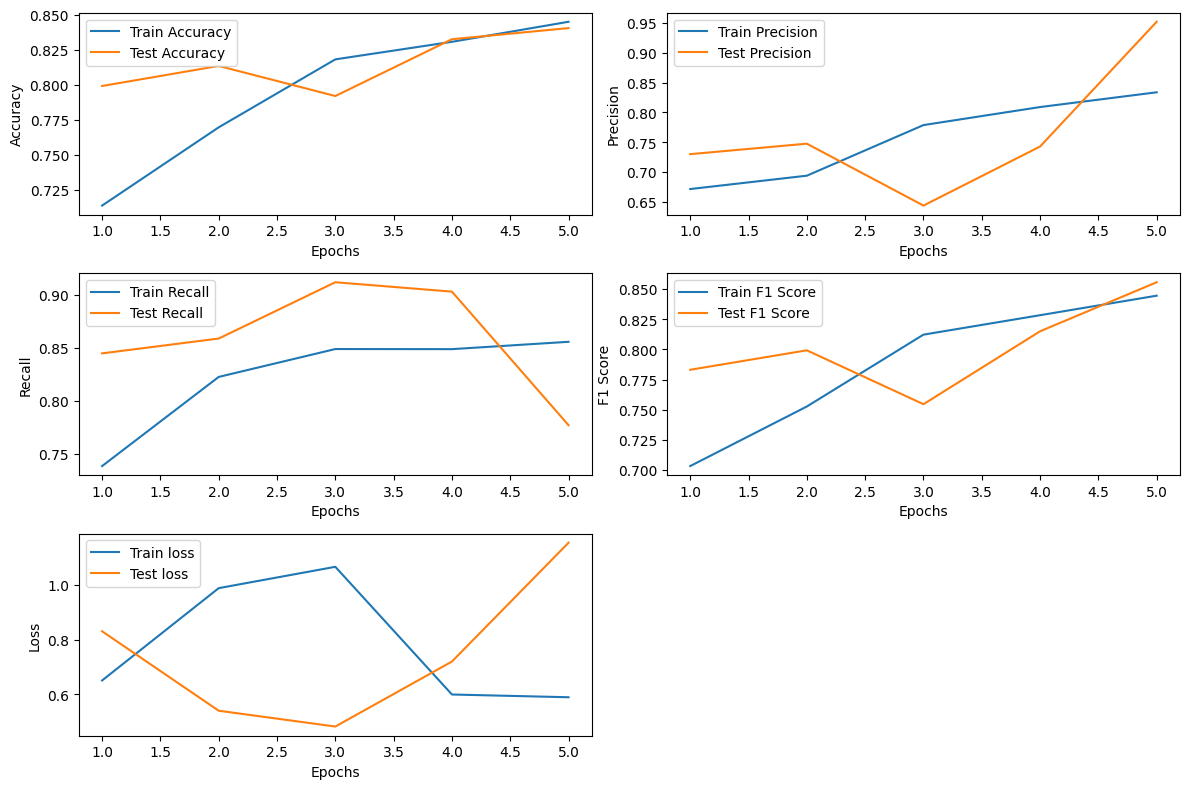

In [25]:
vocab_size = len(model_w2v.wv.index_to_key)
emb_size = 80

A = len(df2)
# A = 5

net = SentimentRNN(embedding_dim = emb_size, hidden_dim = 64, n_layers = 2, dropout=0.6).to(device)

net.infer(df2.iloc[:A], epochs = 5, batch_size = 32)

### SentimentRNN2:

   This method utilizes a DataLoader to handle the data in batches. Since the inputs must be of uniform length for batching, we first pad the data with zeros to ensure consistency. During the forward pass, we trim these padding zeros before processing the batch to focus only on the actual data. This allows the model to effectively learn from inputs of varying lengths without being influenced by the padding.

In [13]:
#Extra work

default_batch_size = 32

class SentimentRNN2(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_layers, dropout=0.6):
        super(SentimentRNN2, self).__init__()

        self.output_size = 1
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim  

        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(model_w2v.wv.vectors))

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, self.output_size)

        # Sigmoid layer
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        # Embed the input
        lengths = x[:, 0].long()
        #We trim the 0s from the input.
        embeds = [self.embedding(x[i, 1:int(lengths[i].item()) + 1].long()) for i in range(batch_size)]
        embeds = pad_sequence(embeds, batch_first=True)

        # Pack padded sequence
        packed_embeds = pack_padded_sequence(embeds, lengths.to(device), batch_first=True, enforce_sorted=False)

        # LSTM layer
        packed_lstm_out, hidden = self.lstm(packed_embeds, hidden)
        lstm_out, _ = pad_packed_sequence(packed_lstm_out, batch_first=True)

        # Gather the outputs at the last time step for each sequence
        idx = (lengths - 1).view(-1, 1).expand(len(lengths), lstm_out.size(2)).unsqueeze(1)
        lstm_out = lstm_out.gather(1, idx).squeeze(1)

        # Dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # Sigmoid function
        sig_out = self.sig(out)

        return sig_out, hidden


    def init_hidden(self, batch_size):
        """ Initializes hidden state """
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

    def __preprocess(self,df):
        preprocessor = TextPreprocessor()
        # adding the column "clean_text"
        df = preprocessor.add_clean_text_column(df)
        # Filter out rows where 'clean_text' is empty
        df = df[df['clean_text'].str.len() > 0]
        # adding the column "tidy_text" that has the list of tokenized words of the "text" column
        df = preprocessor.tokenize_text_column(df)
        return df

    # split the data into train data and test data
    def data_split(self, df, test_size = 0.2):
        # Assuming your DataFrame is called df
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)

        # Reset index
        train_df = train_df.reset_index(drop=True)
        test_df = test_df.reset_index(drop=True)
        return train_df, test_df

    def train_or_evaluate_epoch(self, phase, df, optimizer, criterion, batch_size):
        if phase == 'train':
            self.train()
        else:
            self.eval()
        
        label_map = {'REAL': 1, 'FAKE': 0}
        Y_df = df['label'].map(label_map)

        # Convert the DataFrame column to a list of lists
        df_list = np.array(df['embeddings'])

        padded_data = pad_sequence([torch.cat([torch.tensor([len(x)]), torch.tensor(x)]) for x in df_list], batch_first=True)
        print("size of padded_data = ", padded_data.size())
        # Create a TensorDataset
        dataset = data_utils.TensorDataset(padded_data, torch.Tensor(Y_df.values))
        df_loader = data_utils.DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=5)

        clip = 5  # Gradient Clipping
        Y_pred = []
        Y_true = []  # Initialize Y_true to accumulate true labels
        loss = 0.0

        # Initialize hidden state
        hidden = self.init_hidden(batch_size)

        for embeddings, labels in df_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            # Zero gradients
            self.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                if embeddings.size(0) != batch_size:
                    # Adjust hidden state for smaller batch sizes
                    hidden = tuple([h[:, :embeddings.size(0), :].contiguous() for h in hidden])

                # Pass the input tensor to the model
                output, hidden = self.forward(embeddings.long(), hidden)

                # Detach hidden state to prevent backprop through entire history
                hidden = tuple([each.data for each in hidden])

                output = output.squeeze()
                # Ensure output and labels are 1-dimensional
                if output.dim() == 0:
                    output = output.unsqueeze(0)
                if labels.dim() == 0:
                    labels = labels.unsqueeze(0)


                # Calculate loss for the batch
                loss = criterion(output, labels.float())
                # Update training loss
                loss += loss.item()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward(retain_graph=False)
                    nn.utils.clip_grad_norm_(self.parameters(), clip)
                    optimizer.step()

                # Prediction and accuracy
                pred = torch.round(output).long()
               # Ensure pred is 1-dimensional for Y_pred
                if pred.dim() == 0:
                    pred = pred.unsqueeze(0)
                # Convert tensors to numpy arrays and then to integers
                Y_pred.extend(pred.detach().cpu().numpy().astype(int))
                Y_true.extend(labels.detach().cpu().numpy().astype(int))

        report_dict = classification_report(Y_pred, Y_true, digits=4, zero_division=1, output_dict=True)
        return report_dict, loss.detach().numpy()

    def train_and_evaluate(self, train_df, test_df, optimizer, criterion, epochs, batch_size):
        metrics = {'train': [], 'test': []}
        for epoch in range(0, epochs):
            print("epoch = ", epoch + 1)

            print("Report on the train data after {} epochs:".format(epoch + 1))
            report_dict_train, train_loss = self.train_or_evaluate_epoch('train', train_df, optimizer, criterion, batch_size)
            train_metrics = {
                'accuracy': report_dict_train['accuracy'],
                'precision': report_dict_train.get('1', {}).get('precision', 0),
                'recall': report_dict_train.get('1', {}).get('recall', 0),
                'f1_score': report_dict_train.get('1', {}).get('f1-score', 0),
                'train_loss': train_loss
            }     
            metrics['train'].append(train_metrics)
            
            accuracy_train = train_metrics['accuracy']
            if '1' in report_dict_train:
                precision_real = report_dict_train['1']['precision']
                recall_real = report_dict_train['1']['recall']
                f1_score_real = report_dict_train['1']['f1-score']
                print(f"Precision: {precision_real}, Recall: {recall_real}, F1-score: {f1_score_real}, Accuracy: {accuracy_train}")
            else:
                precision_real = recall_real = f1_score_real = 0
                print("Class '1' not present in predictions.")
                print(f"Accuracy: {accuracy_train}")
                
            print("Report on the test data after {} epochs:".format(epoch + 1))
            report_dict_test, test_loss = self.train_or_evaluate_epoch('test', test_df, optimizer, criterion, batch_size)
            test_metrics = {
                'accuracy': report_dict_test['accuracy'],
                'precision': report_dict_test.get('1', {}).get('precision', 0),
                'recall': report_dict_test.get('1', {}).get('recall', 0),
                'f1_score': report_dict_test.get('1', {}).get('f1-score', 0),
                'test_loss': test_loss
            }          

            accuracy_test = test_metrics['accuracy']
            if '1' in report_dict_test:
                precision_real = report_dict_test['1']['precision']
                recall_real = report_dict_test['1']['recall']
                f1_score_real = report_dict_test['1']['f1-score']
                print(f"Precision: {precision_real}, Recall: {recall_real}, F1-score: {f1_score_real}, Accuracy: {accuracy_test}")
            else:
                precision_real = recall_real = f1_score_real = 0
                print("Class '1' not present in predictions.")
                print(f"Accuracy: {accuracy_test}")

            metrics['test'].append(test_metrics)
            print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
            print(" ")

        print("Training completed.")
        return metrics
    

    def plot_metrics(self, metrics):
        epochs = range(1, len(metrics['train']) + 1)

        train_accuracy = [m['accuracy'] for m in metrics['train']]
        test_accuracy = [m['accuracy'] for m in metrics['test']]

        train_precision = [m['precision'] for m in metrics['train']]
        test_precision = [m['precision'] for m in metrics['test']]

        train_recall = [m['recall'] for m in metrics['train']]
        test_recall = [m['recall'] for m in metrics['test']]

        train_f1_score = [m['f1_score'] for m in metrics['train']]
        test_f1_score = [m['f1_score'] for m in metrics['test']]

        train_loss = [m['train_loss'] for m in metrics['train']]
        test_loss = [m['test_loss'] for m in metrics['test']]

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 2, 1)
        plt.plot(epochs, train_accuracy, label='Train Accuracy')
        plt.plot(epochs, test_accuracy, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(3, 2, 2)
        plt.plot(epochs, train_precision, label='Train Precision')
        plt.plot(epochs, test_precision, label='Test Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

        plt.subplot(3, 2, 3)
        plt.plot(epochs, train_recall, label='Train Recall')
        plt.plot(epochs, test_recall, label='Test Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

        plt.subplot(3, 2, 4)
        plt.plot(epochs, train_f1_score, label='Train F1 Score')
        plt.plot(epochs, test_f1_score, label='Test F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()

        plt.subplot(3, 2, 5)
        plt.plot(epochs, train_loss, label='Train loss')
        plt.plot(epochs, test_loss, label='Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def infer(self, df, epochs, criterion=nn.BCELoss(), batch_size = default_batch_size):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        train_df, test_df = self.data_split(df)
        metrics = self.train_and_evaluate(train_df, test_df, optimizer, criterion, epochs, batch_size) 
        
        self.plot_metrics(metrics)


## Performance of SentimentRNN model with 2 hidden layers on LSTM.

- For Batch_size=32, we get %851 accuracy on the train data nad %856 on the test data after five epochs. See below.

epoch =  1
Report on the train data after 1 epochs:
size of padded_data =  torch.Size([5038, 10118])
Precision: 0.7854616895874263, Recall: 0.7139285714285715, F1-score: 0.7479887745556595, Accuracy: 0.7326319968241366
Report on the test data after 1 epochs:
size of padded_data =  torch.Size([1260, 7507])
Precision: 0.9472843450479234, Recall: 0.6927570093457944, F1-score: 0.8002699055330634, Accuracy: 0.765079365079365
Epoch: 1/5, Train Loss: 1.280787, Test Loss: 1.331084
 
epoch =  2
Report on the train data after 2 epochs:
size of padded_data =  torch.Size([5038, 10118])
Precision: 0.8023575638506876, Recall: 0.8267206477732794, F1-score: 0.8143569292123629, Accuracy: 0.815204446208813
Report on the test data after 2 epochs:
size of padded_data =  torch.Size([1260, 7507])
Precision: 0.8753993610223643, Recall: 0.8154761904761905, F1-score: 0.8443759630200308, Accuracy: 0.8396825396825397
Epoch: 2/5, Train Loss: 0.860394, Test Loss: 0.419067
 
epoch =  3
Report on the train data afte

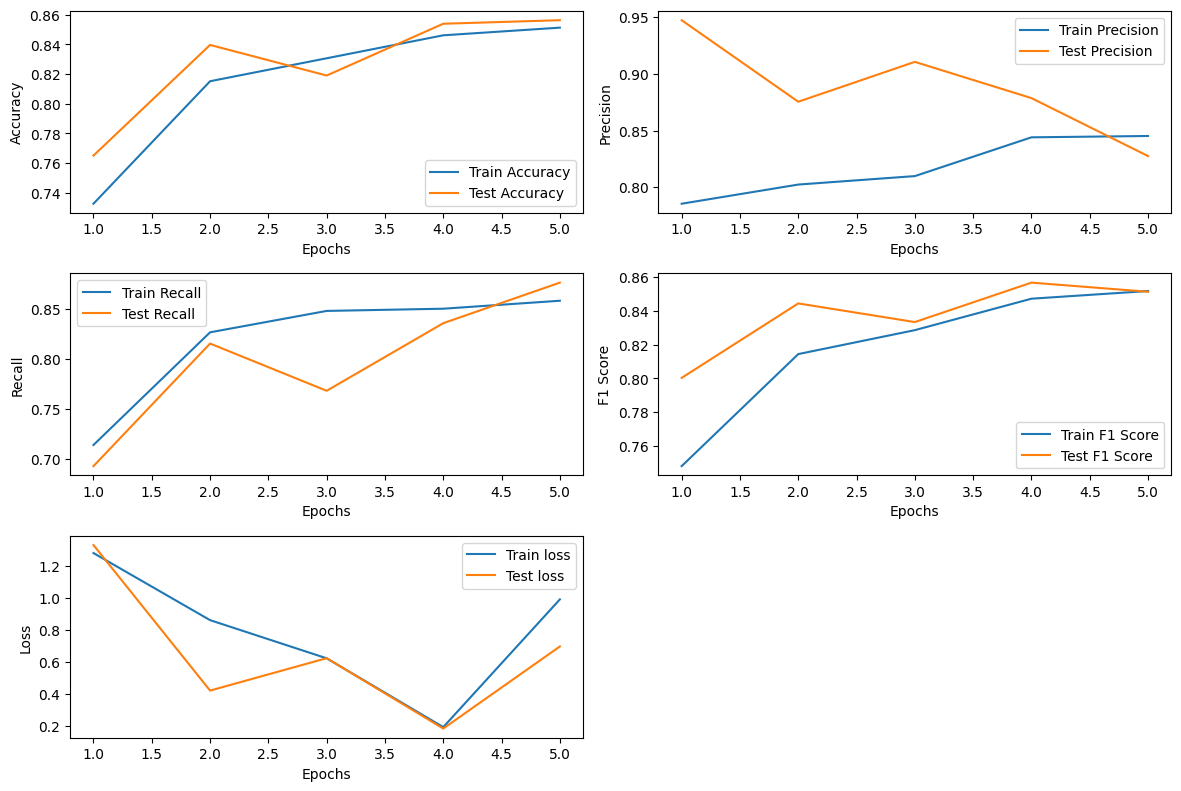

In [21]:
vocab_size = len(model_w2v.wv.index_to_key)
 
A = len(df2)

net = SentimentRNN2(embedding_dim = emb_size, hidden_dim = 64, n_layers = 2, dropout=0.6).to(device)

net.infer(df2.iloc[:A], epochs = 5, batch_size = 32)

# Model BERTForClassification using Bert

In [11]:
default_batch_size = 32

class BERTForClassification(nn.Module):
    def __init__(self, bert, n_class, device='cpu'):
        super().__init__()
        assert n_class > 1, ValueError("number of class must be larger than 1")
        self.n_class = n_class
        self.bert = bert.to(device)
        self.device = device
        # vars
        self.output_layer = nn.Linear(self.bert.config.hidden_size, n_class).to(device)

    def forward(self, **inputs):
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)
        token_type_ids = inputs['token_type_ids'].to(self.device)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_emb = outputs.last_hidden_state[:,0,:]
        return self.output_layer(cls_emb)

    # split the data into train data and test data
    def data_split(self, df, test_size = 0.2):
        # Assuming your DataFrame is called df
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=44)

        # Reset index
        train_df = train_df.reset_index(drop=True)
        test_df = test_df.reset_index(drop=True)
        return train_df, test_df

    def train_or_evaluate_epoch(self, phase, df, max_length, tokenizer, optimizer, criterion, batch_size, max_grad_norm=1.0):
        if phase == 'train':
            self.train()
        else:
            self.eval()

        label_map = {'REAL': 1, 'FAKE': 0}

        clip = 5  # Gradient Clipping
        Y_pred = []
        Y_true = []  # Initialize Y_true to accumulate true labels
        loss = 0.0

        for i in range(0, len(df), batch_size):
            # print("i = ", i)
            batch_df = df.iloc[i : min(i + batch_size, len(df))]

            X_train = batch_df['clean_text'].tolist()
            Y_train = batch_df['label'].map(label_map).tolist()

            inputs = tokenizer(X_train, return_tensors="pt", truncation=True, max_length=max_length, padding=True)
            inputs = {key: val.to(device) for key, val in inputs.items()}

            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            token_type_ids = inputs['token_type_ids'].to(device)

            labels = torch.tensor(Y_train).to(device)
            
            optimizer.zero_grad()
            logits = self.forward(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            loss = criterion(logits, labels)
            loss += loss.item()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward(retain_graph=False)
                # Gradient Clipping
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_grad_norm)
                optimizer.step()
            
            _, predicted = torch.max(logits, 1)
            # Collect predictions for this batch
            Y_pred.extend(predicted.tolist())
            # Convert tensors to numpy arrays and then to integers
            # Y_pred.extend(pred.detach().cpu().numpy().astype(int))
            Y_true.extend(labels.detach().cpu().numpy().astype(int))

        report_dict = classification_report(Y_pred, Y_true, digits=4, zero_division=1, output_dict=True)

        return report_dict, loss.detach().numpy()
            
    def train_and_evaluate(self, train_df, test_df, max_length, tokenizer, optimizer, criterion, epochs, batch_size):
        # print("batch_size = ", batch_size)
        metrics = {'train': [], 'test': []}
        for epoch in range(0, epochs):
            print("epoch =", epoch + 1)

            print("Report on the train data after {} epochs:".format(epoch + 1))
            report_dict_train, train_loss = self.train_or_evaluate_epoch('train', train_df, max_length, tokenizer, optimizer, criterion, batch_size)
            train_metrics = {
                'accuracy': report_dict_train['accuracy'],
                'precision': report_dict_train.get('1', {}).get('precision', 0),
                'recall': report_dict_train.get('1', {}).get('recall', 0),
                'f1_score': report_dict_train.get('1', {}).get('f1-score', 0),
                'train_loss': train_loss
            }     
            metrics['train'].append(train_metrics)
            
            accuracy_train = train_metrics['accuracy']
            if '1' in report_dict_train:
                precision_real = report_dict_train['1']['precision']
                recall_real = report_dict_train['1']['recall']
                f1_score_real = report_dict_train['1']['f1-score']
                print(f"Precision: {precision_real}, Recall: {recall_real}, F1-score: {f1_score_real}, Accuracy: {accuracy_train}")
            else:
                precision_real = recall_real = f1_score_real = 0
                print("Class '1' not present in predictions.")
                print(f"Accuracy: {accuracy_train}")

            print("Report on the test data after {} epochs:".format(epoch + 1))

            report_dict_test, test_loss = self.train_or_evaluate_epoch('test', test_df, max_length, tokenizer, optimizer, criterion, batch_size)
            test_metrics = {
                'accuracy': report_dict_test['accuracy'],
                'precision': report_dict_test.get('1', {}).get('precision', 0),
                'recall': report_dict_test.get('1', {}).get('recall', 0),
                'f1_score': report_dict_test.get('1', {}).get('f1-score', 0),
                'test_loss': test_loss
            }          

            accuracy_test = test_metrics['accuracy']
            if '1' in report_dict_test:
                precision_real = report_dict_test['1']['precision']
                recall_real = report_dict_test['1']['recall']
                f1_score_real = report_dict_test['1']['f1-score']
                print(f"Precision: {precision_real}, Recall: {recall_real}, F1-score: {f1_score_real}, Accuracy: {accuracy_test}")
            else:
                precision_real = recall_real = f1_score_real = 0
                print("Class '1' not present in predictions.")
                print(f"Accuracy: {accuracy_test}")
                print(" ")

            metrics['test'].append(test_metrics)
            print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
            print(" ")

            # print("Report on the test data after {} epochs:".format(epoch + 1))
            # self.evaluate_model(test_df, criterion)
        print("Training completed.")
        return metrics

    def plot_metrics(self, metrics):
        epochs = range(1, len(metrics['train']) + 1)

        train_accuracy = [m['accuracy'] for m in metrics['train']]
        test_accuracy = [m['accuracy'] for m in metrics['test']]

        train_precision = [m['precision'] for m in metrics['train']]
        test_precision = [m['precision'] for m in metrics['test']]

        train_recall = [m['recall'] for m in metrics['train']]
        test_recall = [m['recall'] for m in metrics['test']]

        train_f1_score = [m['f1_score'] for m in metrics['train']]
        test_f1_score = [m['f1_score'] for m in metrics['test']]

        train_loss = [m['train_loss'] for m in metrics['train']]
        test_loss = [m['test_loss'] for m in metrics['test']]

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 2, 1)
        plt.plot(epochs, train_accuracy, label='Train Accuracy')
        plt.plot(epochs, test_accuracy, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(3, 2, 2)
        plt.plot(epochs, train_precision, label='Train Precision')
        plt.plot(epochs, test_precision, label='Test Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

        plt.subplot(3, 2, 3)
        plt.plot(epochs, train_recall, label='Train Recall')
        plt.plot(epochs, test_recall, label='Test Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

        plt.subplot(3, 2, 4)
        plt.plot(epochs, train_f1_score, label='Train F1 Score')
        plt.plot(epochs, test_f1_score, label='Test F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()

        plt.subplot(3, 2, 5)
        plt.plot(epochs, train_loss, label='Train loss')
        plt.plot(epochs, test_loss, label='Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    def infer(self, df, max_length, tokenizer, criterion=nn.CrossEntropyLoss(), epochs = 3, batch_size = default_batch_size):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-5)
        train_df, test_df = self.data_split(df)
        # epochs = 3
        metrics = self.train_and_evaluate(train_df, test_df, max_length, tokenizer, optimizer, criterion, epochs, batch_size)
        self.plot_metrics(metrics)


## Performance of BERTForClassification model using Bert.

- For Batch_size=32, we get %99.2 accuracy on the train data nad %92.6 on the test data after five epochs. See below.

epoch = 1
Report on the train data after 1 epochs:
Precision: 0.8254156769596199, Recall: 0.8062645011600929, F1-score: 0.8157276995305164, Accuracy: 0.8130210400952759
Report on the test data after 1 epochs:
Precision: 0.8015503875968992, Recall: 0.962756052141527, F1-score: 0.8747884940778342, Accuracy: 0.8825396825396825
Epoch: 1/5, Train Loss: 0.269355, Test Loss: 0.429530
 
epoch = 2
Report on the train data after 2 epochs:
Precision: 0.9311163895486936, Recall: 0.9311163895486936, F1-score: 0.9311163895486936, Accuracy: 0.9309249702262803
Report on the test data after 2 epochs:
Precision: 0.9751937984496124, Recall: 0.8884180790960452, F1-score: 0.9297856614929786, Accuracy: 0.9246031746031746
Epoch: 2/5, Train Loss: 0.331729, Test Loss: 0.024408
 
epoch = 3
Report on the train data after 3 epochs:
Precision: 0.9619952494061758, Recall: 0.972, F1-score: 0.9669717469160366, Accuracy: 0.9670504168320763
Report on the test data after 3 epochs:
Precision: 0.9751937984496124, Recall: 

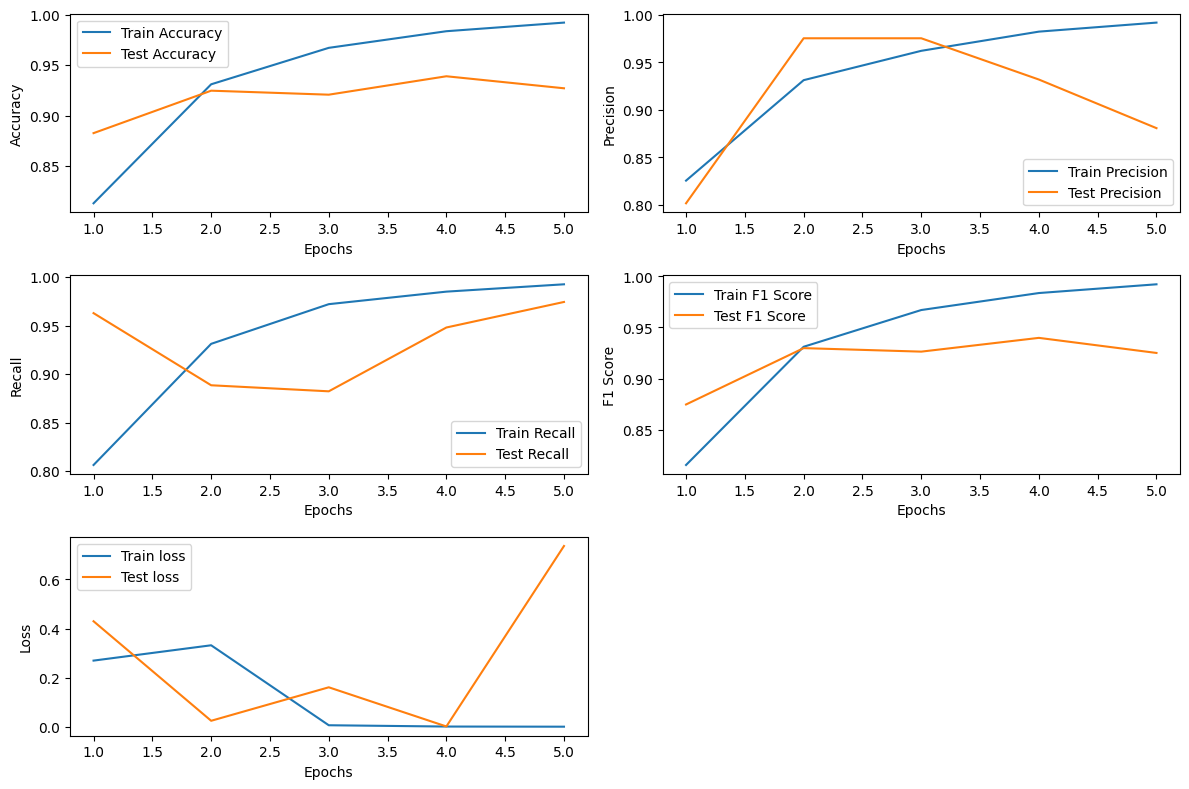

In [12]:
A = len(df)

# A = 7 * 32   # the variable A was used to test the model on a smaller number of rows in dataframe df

epochs = 5
max_length = 100
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

bert = BertModel.from_pretrained("bert-base-uncased")
model_BERT = BERTForClassification(bert, 2, device = device)

model_BERT.infer(df.iloc[:A], max_length = max_length, tokenizer = tokenizer, epochs = epochs, batch_size = 32)